In [1]:
import torch
import pyro.distributions as dist
import pyro
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
print(pyro.__version__)

1.8.2+2e3bd02


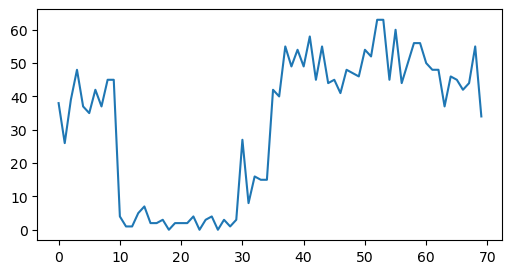

In [4]:
def generate_data():

    true_rates = [40, 3, 20, 50]
    true_durations = [10, 20, 5, 35]

    obs = [
        dist.Poisson(rate).expand([steps]).sample() \
            for rate, steps in zip(true_rates, true_durations)
            ]
    
    states = torch.concatenate(
        [torch.full(i.size(), k) for k, i in enumerate(obs)]
        )

    return states, torch.concatenate(obs)

states, emissions = generate_data()

plt.figure(figsize=(6, 3))
plt.plot(torch.arange(0, len(emissions)), emissions);

In [5]:
transition_probs = torch.tensor(
    [[0.95, 0.01666667, 0.01666667, 0.01666667],
    [0.01666667, 0.95, 0.01666667, 0.01666667],
    [0.01666667, 0.01666667, 0.95, 0.01666667],
    [0.01666667, 0.01666667, 0.01666667, 0.95]])

In [6]:
num_states = 4
num_obs = 10
duration = 70
init_prior = torch.ones((num_states,)) / (num_states * 1.0)

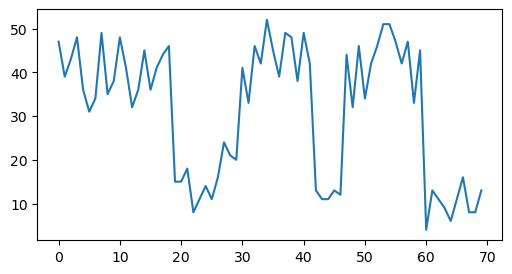

In [10]:
rate_prior = pyro.sample('rate', dist.LogNormal(3., 1.).expand([4]))
emission_probs = dist.Poisson(rate_prior).expand([70, 4])

# batch size of emission_probs indicates: p(y_t | Z = z_k)
hmm = dist.DiscreteHMM(
    initial_logits=init_prior.log(),
    transition_logits=transition_probs.log(),
    observation_dist=emission_probs,
    duration=70
).sample()

plt.figure(figsize=(6, 3))
plt.plot(torch.arange(0, len(states)), hmm);

In [11]:
def model_2(states, output):

    num_states = len(torch.unique(states))

    # prior params. of Poisson rate (lambda)
    emission_prior_loc = 1.
    emission_prior_scale = 1.

    # uniform prior probs. of state Z = z
    init_probs = torch.ones((num_states,)) / (num_states * 1.0)

    # prior dist. of Poisson rate
    rate_prior = pyro.sample('emission_prior', dist.LogNormal(
        loc=emission_prior_loc,
        scale=emission_prior_scale).expand([4])
        )

    transition_probs = torch.tensor(
        [[0.95, 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.95, 0.01666667, 0.01666667],
        [0.01666667, 0.01666667, 0.95, 0.01666667],
        [0.01666667, 0.01666667, 0.01666667, 0.95]
        ])
    
    # learn the transition probabilities
    trans_dist = pyro.sample(
        'Aij', dist.Dirichlet(transition_probs)
        )

    #with pyro.plate('sequences', len(states)):

    obs_dist = dist.Poisson(rate_prior).expand([70, 4])

    hmm_dist = dist.DiscreteHMM(
        torch.logit(init_probs),
        torch.logit(trans_dist),
        obs_dist,
        duration=len(states)
        )

    pyro.sample('y', hmm_dist, obs=output)

    return hmm_dist


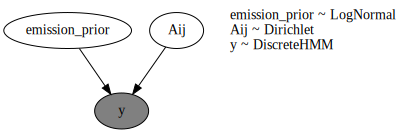

In [12]:
pyro.render_model(model_2, (states, emissions), render_distributions=True)

In [13]:
nuts_kernel = NUTS(model_2, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=100)
mcmc.run(states, emissions)

Sample: 100%|██████████| 400/400 [07:32,  1.13s/it, step size=1.81e-02, acc. prob=0.855]


In [14]:
mcmc.summary() 


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
         Aij[0,0]      0.83      0.08      0.84      0.72      0.98       nan      1.00
         Aij[0,1]      0.00      0.02      0.00      0.00      0.00       nan      1.00
         Aij[0,2]      0.15      0.09      0.15      0.00      0.26       nan      1.01
         Aij[0,3]      0.02      0.04      0.00      0.00      0.05       nan      1.03
         Aij[1,0]      0.00      0.01      0.00      0.00      0.00       nan      1.01
         Aij[1,1]      0.99      0.03      1.00      0.95      1.00       nan      1.00
         Aij[1,2]      0.00      0.01      0.00      0.00      0.00       nan      1.00
         Aij[1,3]      0.01      0.03      0.00      0.00      0.04       nan      1.00
         Aij[2,0]      0.00      0.00      0.00      0.00      0.00       nan       nan
         Aij[2,1]      0.27      0.13      0.28      0.05      0.45       nan      1.01
         Aij[2,2]      0.71    

In [15]:
samples = mcmc.get_samples(1000)
posterior_predictive = Predictive(model_2, samples)(states, None)

In [16]:
posterior_predictive['y'].shape

torch.Size([1000, 70])

In [17]:
state_0 = samples['emission_prior'][:, 0]
state_1 = samples['emission_prior'][:, 1]
state_2 = samples['emission_prior'][:, 2]
state_3 = samples['emission_prior'][:, 3]

In [18]:
state_0.mean(), state_1.mean(), state_2.mean(), state_3.mean()

(tensor(2.4759), tensor(48.9215), tensor(15.7172), tensor(38.9299))